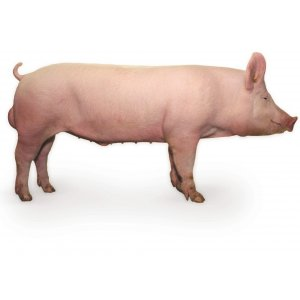

In [1]:
from IPython.display import Image,display
path = "../picture/pig.jpg"
display(Image(filename=path))

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

img_path = path
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)

print('Predicted:', decode_predictions(preds, top=3)[0])

Using TensorFlow backend.


Predicted: [('n02395406', 'hog', 0.98398596), ('n02396427', 'wild_boar', 0.0074134255), ('n03935335', 'piggy_bank', 0.006954492)]


In [3]:
import os
import numpy as np
import torch
import torch.nn
import torchvision.models as models
from torch.autograd import Variable 
import torch.cuda
import torchvision.transforms as transforms
from PIL import Image

resnet50=models.resnet50(pretrained=True).eval()

img=Image.open(path)
img=img.resize((224,224))
img = np.array(img).copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)
img = Variable(torch.from_numpy(img).float())

label=np.argmax(resnet50(img).data.cpu().numpy())
print("label={}".format(label))

label=341


In [4]:
print('Predicted:', decode_predictions(resnet50(img).data.cpu().numpy(), top=3)[0])

Predicted: [('n02395406', 'hog', 15.661886), ('n02396427', 'wild_boar', 10.353137), ('n03935335', 'piggy_bank', 10.098382)]


In [5]:
from mxnet import gluon
import mxnet as mx
from mxnet.gluon import nn
from mxnet import ndarray as nd
from mxnet import autograd
import numpy as np

resnet=mx.gluon.model_zoo.vision.resnet50_v2(pretrained=True)

img=Image.open(path)
img=img.resize((224,224))
img = np.array(img).copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)
array = mx.nd.array(img)

outputs=resnet(array).asnumpy()
label = np.argmax(outputs)
print(label)


341


In [8]:
import tensorflow as tf
import numpy as np
import re
from PIL import Image

class NodeLookup(object):
  """Converts integer node ID's to human readable labels."""

  def __init__(self,
               label_lookup_path=None,
               uid_lookup_path=None):
    self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

  def load(self, label_lookup_path, uid_lookup_path):
    """Loads a human readable English name for each softmax node.
    Args:
      label_lookup_path: string UID to integer node ID.
      uid_lookup_path: string UID to human-readable string.
    Returns:
      dict from integer node ID to human-readable string.
    """
    if not tf.gfile.Exists(uid_lookup_path):
      tf.logging.fatal('File does not exist %s', uid_lookup_path)
    if not tf.gfile.Exists(label_lookup_path):
      tf.logging.fatal('File does not exist %s', label_lookup_path)

    # Loads mapping from string UID to human-readable string
    proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
    uid_to_human = {}
    p = re.compile(r'[n\d]*[ \S,]*')
    for line in proto_as_ascii_lines:
      parsed_items = p.findall(line)
      uid = parsed_items[0]
      human_string = parsed_items[2]
      uid_to_human[uid] = human_string

    # Loads mapping from string UID to integer node ID.
    node_id_to_uid = {}
    proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
    for line in proto_as_ascii:
      if line.startswith('  target_class:'):
        target_class = int(line.split(': ')[1])
      if line.startswith('  target_class_string:'):
        target_class_string = line.split(': ')[1]
        node_id_to_uid[target_class] = target_class_string[1:-2]

    # Loads the final mapping of integer node ID to human-readable string
    node_id_to_name = {}
    for key, val in node_id_to_uid.items():
      if val not in uid_to_human:
        tf.logging.fatal('Failed to locate: %s', val)
      name = uid_to_human[val]
      node_id_to_name[key] = name

    return node_id_to_name

  def id_to_string(self, node_id):
    if node_id not in self.node_lookup:
      return ''
    return self.node_lookup[node_id]


path = "../picture/pig.jpg"
image_data = tf.gfile.FastGFile(path, "rb").read()

session=tf.Session()

def create_graph(dirname):
    with tf.gfile.FastGFile(dirname, 'rb') as f:
        graph_def = session.graph_def
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

create_graph("models/classify_image_graph_def.pb")
session.run(tf.global_variables_initializer())

#tensorlist=[n.name for n in session.graph_def.node]

#print(tensorlist)

logits=session.graph.get_tensor_by_name('softmax/logits:0')
x = session.graph.get_tensor_by_name('DecodeJpeg/contents:0')

predictions=session.run(logits,feed_dict={x:image_data})
predictions = np.squeeze(predictions)

node_lookup = NodeLookup(label_lookup_path="models/imagenet_2012_challenge_label_map_proto.pbtxt",
                        uid_lookup_path="models/imagenet_synset_to_human_label_map.txt")

top_k = predictions.argsort()[-3:][::-1]
for node_id in top_k:
      human_string = node_lookup.id_to_string(node_id)
      score = predictions[node_id]
      print('%s (score = %.5f)' % (human_string, score))

hog, pig, grunter, squealer, Sus scrofa (score = 10.06510)
piggy bank, penny bank (score = 6.92089)
wild boar, boar, Sus scrofa (score = 5.47446)


In [87]:
import tensorflow as tf
import numpy as np
import sys
from PIL import Image
sys.path.append("models/models/research/")
sys.path.append("models/models/research/slim/")
from nets import resnet_v2
import slim.preprocessing.inception_preprocessing 
from datasets import imagenet
from tensorflow.contrib import slim

with tf.Graph().as_default():
    path = "../picture/pig.jpg"
    image = tf.image.decode_jpeg(tf.gfile.FastGFile(path,'rb').read(), channels=3)
    image_size = resnet_v2_50.default_image_size 
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    with slim.arg_scope(resnet_v2.resnet_arg_scope()):
        logits, _ = resnet_v2.resnet_v2_50(processed_images, num_classes=1001, is_training=False)
    probabilities = tf.nn.softmax(logits)
      
    saver=tf.train.Saver()
    
    with tf.Session() as sess:
        saver.restore(sess,'models/resnet_v2_50/resnet_v2_50.ckpt')
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index]))

INFO:tensorflow:Restoring parameters from models/resnet_v2_50/resnet_v2_50.ckpt
Probability 99.08% => [hog, pig, grunter, squealer, Sus scrofa]
Probability 0.84% => [piggy bank, penny bank]
Probability 0.03% => [wild boar, boar, Sus scrofa]
Probability 0.01% => [French bulldog]
Probability 0.01% => [hippopotamus, hippo, river horse, Hippopotamus amphibius]
